In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, Dropout


import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics, svm

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

import pickle

import tracer

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

## Context: the tracer test as forward in the inverse problem

We generated a synthetic geological 2D reference which contains 4 geological facies.
With each facies a permeability, conductivity and specific storage valueis uniquely assigned.
The permeability, conductivity and specific storage are parameters needed to solve transport problem of a tracer, which is injected at x=25, y=50. A pumping well is placed at x=75, y=50 and concentration of the tracer is measured during 20 days.
A geology maps uniquely to the concentration curve. Then, the concentration curve is used to compute the likelihood of the model.

During the solution of the inverse problem, geological models are generated and the concentration curve is computed for each model using MODFLOW with transport module. However, MODFLOW computation is very expensive (around 30 min per simulation). We would like to limit the number of MODFLOW calls. First, we generate 500 pairs geology and concentration. Using this dataset, we want to train a ML model that would estimate the siginificance of likelihood (high/low) of new models.

The goal is to use Machine Learning (ML) to map from the geology 2D categorical image 100x100 to the likelihood class (good=high=1, bad=low=0).

In [2]:
with open('ref/ref-img-val.pickle', 'rb') as file_handle:
    img_ref = pickle.load(file_handle)

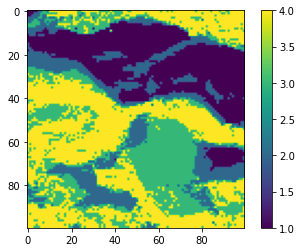

In [3]:
# the reference geology
plt.imshow(img_ref)
plt.colorbar()

In [4]:
def normed(x, xmax, xmin):
    return (x-xmin)/(xmax-xmin)
    

In [5]:
def backnormed(x, xmax, xmin):
    return x*(xmax-xmin)+xmin

In [6]:
def img_to_k(img):
    k = np.array(img, dtype='float32', copy=True)
    k[k==4] = 1e-1
    k[k==3] = 1e-3
    k[k==2] = 1e-4
    k[k==1] = 1e-5
    #return normed(k, 1e-1, 1e-5)
    return k

def img_to_porosity(img):
    porosity = np.array(img, dtype='float32', copy=True)
    porosity[porosity==4] = 0.25
    porosity[porosity==3] = 0.30
    porosity[porosity==2] = 0.35
    porosity[porosity==1] = 0.40
    #return normed(porosity, 0.4, 0.25)
    return porosity

def img_to_specificstorage(img):
    ss = np.array(img, dtype='float32', copy=True)
    ss[ss==4] = 1e-5
    ss[ss==3] = 1e-4
    ss[ss==2] = 5e-4
    ss[ss==1] = 1e-3
    return normed(ss, 1e-3, 1e-5)

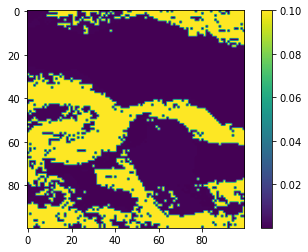

In [7]:
plt.imshow(img_to_k(img_ref))
plt.colorbar()

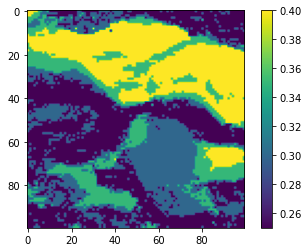

In [8]:
plt.imshow(img_to_porosity(img_ref))
plt.colorbar()

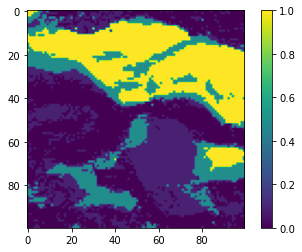

In [9]:
plt.imshow(img_to_specificstorage(img_ref))
plt.colorbar()

In [10]:
with open('ref/measurement-4.pickle', 'rb') as file_handle:
    concentrations_ref = pickle.load(file_handle)

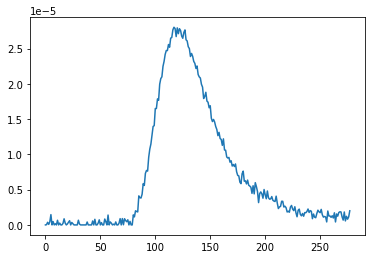

In [11]:
# the reference concentration curve
plt.plot(concentrations_ref[:])

For computation of the likelihood only 6 values sampled from the concentration cruve are used.
They are sampled at the following indexes:

In [12]:
ind = [50, 100, 125, 150, 200, 250]

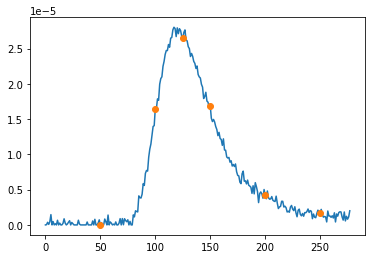

In [13]:
# the reference concentration curve
plt.plot(concentrations_ref[:])
plt.plot(ind, concentrations_ref[ind], 'o')

We can either use ML to estimate the mismatch directly, or try to estimate the 6 values on the concentration curve, or output YES/NO if mismatch is among 100 best.

I propose the following approach: use conductivity, porosity and specific storage. It results in (100,100,3) array for each model, filled with positive values. Normalize them. Then train a ML classifier on yes/no whether the model is among the 10% best in terms of likelihood.

## The dataset

In [14]:
N_POPEX = 500
# helper popex object
with open(f'popex-{N_POPEX}/popex.pop', 'rb') as file_handle:
    popex_object = pickle.load(file_handle)

In [15]:
def get_pickle(name):
    result = None
    try:
        with open(name, 'rb') as file_handle:
            result = pickle.load(file_handle)
    except FileNotFoundError as e:
        print(f'{name} failed: {str(e)}')
    return result

In [16]:
def get_vx(heads):
    vx = (heads[2:,:] - heads[:-2,:]) / 2
    return vx[:,1:-1]

def get_vy(heads):
    vy = (heads[:,2:] - heads[:,:-2]) / 2
    return vy[1:-1,:]

def get_red_porosity(porosity):
    return porosity[1:-1, 1:-1]

In [17]:
def _compute_heads(img, name, popex_dir, write_pickle=True):
    steady_state = tracer.TracerTest(cell_divisions=1, working_dir='modflow-steady-500')
    steady_state.run_steady(img, name=name)
    heads = steady_state.get_heads(name=name)
    if write_pickle:
        with open(_heads_file(name, popex_dir=popex_dir), 'wb') as file_handle:
            pickle.dump(heads, file_handle)
    steady_state.remove_modflow_workspace(name=name)
    return heads

def _compute_heads_from_tuple(img_tuple, popex_dir):
    for i,img in enumerate(img_tuple):
        name = f'{i}'
        _compute_heads(img, name, popex_dir)
        

def _heads_file(name, popex_dir):
    return f'heads-500/heads-{name}.pickle'

In [18]:
# load "good" concentrations
concentration_tuple = tuple(get_pickle(f'concentrations-{N_POPEX}/flow-{i}-concentration.pickle') for i in range(N_POPEX))
model_tuple = tuple(get_pickle(f'popex-{N_POPEX}/{i}') for i in popex_object.model[:N_POPEX])
img_tuple = tuple(i[0].param_val.reshape((100,100)) for i in model_tuple)

In [19]:
try:
    heads_transformed_tuple = tuple(get_pickle(f'heads-{N_POPEX}/heads-{i}.pickle')[0,0,:,:]+0.5 for i in range(N_POPEX))
except TypeError:
    _compute_heads_from_tuple(img_tuple, 'popex-500')
    heads_transformed_tuple = tuple(get_pickle(f'heads-{N_POPEX}/heads-{i}.pickle')[0,0,:,:]+0.5 for i in range(N_POPEX))

In [20]:
porosity_tuple = tuple(img_to_porosity(img) for img in img_tuple)
k_tuple = tuple(img_to_k(img) for img in img_tuple)
ss_tuple = tuple(img_to_specificstorage(img) for img in img_tuple)
red_porosity_tuple = tuple(get_red_porosity(porosity) for porosity in porosity_tuple)
red_k_tuple = tuple(get_red_porosity(k) for k in k_tuple)
vx_tuple = tuple(get_vx(heads) for heads in heads_transformed_tuple)
vy_tuple = tuple(get_vy(heads) for heads in heads_transformed_tuple)

vxp_tuple = tuple(vx*k/p for vx, p, k in zip(vx_tuple, red_porosity_tuple, red_k_tuple))
vyp_tuple = tuple(vy*k/p for vy, p, k in zip(vy_tuple, red_porosity_tuple, red_k_tuple))

The input data is in img_tuple (500 examples). The full output (concentraion curves) is in concentration_tuple

In [21]:
def norm_tuple(i_tuple):
    min_val = np.min(np.array(i_tuple))
    max_val = np.max(np.array(i_tuple))
    return tuple(normed(x, max_val, min_val) for x in i_tuple)

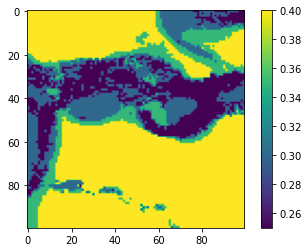

In [22]:
# example input porosity
plt.imshow(porosity_tuple[10])
plt.colorbar()

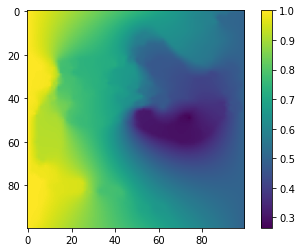

In [23]:
plt.imshow(heads_transformed_tuple[10])
plt.colorbar()

In [24]:
sorter = np.argsort(-popex_object.log_p_lik)

### Convert input to physical features and sample from output

In [25]:
# 500 samples 100x100 each with 2 channels
#X = np.stack([ np.stack([p, h], axis=2) for p,h in zip(porosity_tuple, heads_transformed_tuple) ])
#X = np.stack([ np.stack([p, k, ss], axis=2) for p,k,ss in zip(porosity_tuple, k_tuple, ss_tuple) ])
#X = np.stack([ np.stack([p, vx, vy], axis=2) for p,vx,vy in zip(red_porosity_tuple, vx_tuple, vy_tuple) ])
#X = np.stack([ np.stack([vx, vy, vxp, vyp], axis=2) for vx,vy,vxp,vyp in zip(vxp_tuple, vyp_tuple, vx_tuple, vy_tuple) ])
X = np.stack([ np.stack([vx, vy], axis=2) for vx,vy in zip(vxp_tuple, vyp_tuple) ])
#X = np.stack([ np.stack([vx**2 + vy**2], axis=2) for vx,vy in zip(vxp_tuple, vyp_tuple) ])
#X = np.stack([ np.stack([vx], axis=2) for vx,vy in zip(vxp_tuple, vyp_tuple) ])
X.shape

(500, 98, 98, 2)

In [26]:
y = np.zeros((N_POPEX,))
y[sorter[:200]] = 1
y.shape

(500,)

In [27]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, shuffle=True)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y, shuffle=True)

In [29]:
X_flat, y_flat = X.reshape(X.shape[0], X.shape[-1]*98*98), y.reshape(y.shape[0])

In [30]:
X_train_flat = X_train.reshape(X_train.shape[0], X.shape[-1]*98*98)
y_train_flat = y_train.reshape(y_train.shape[0])

X_test_flat = X_test.reshape(X_test.shape[0], X.shape[-1]*98*98)
y_test_flat = y_test.reshape(y_test.shape[0])

In [31]:
X_flat.shape

(500, 19208)

## Simple sklearn classifiers

In [32]:
kfold = StratifiedKFold(random_state=1430, shuffle=True, n_splits=5)

In [33]:
classifiers = [
    LogisticRegression(max_iter=10000, class_weight='balanced'),
    AdaBoostClassifier(random_state=123),
    #AdaBoostClassifier(n_estimators=150),
    RandomForestClassifier(class_weight='balanced', random_state=1234),
    #RandomForestClassifier(n_estimators=1000, class_weight='balanced', criterion='entropy'),
]

In [34]:
#Intel(R) Xeon(R) CPU D-1541 @ 2.10GHz
cm = 3.8e2
cg = 1.05e4

In [35]:
alpha = 0.036
p = 200/500

In [36]:
from sklearn.metrics import fbeta_score, make_scorer
speed_scorer = make_scorer(fbeta_score, beta=alpha/p)

In [37]:
sqrt_5 = np.sqrt(5)

In [38]:
for classifier in classifiers:
    print(str(classifier))
    score = cross_validate(classifier, X_flat, y_flat, cv=kfold, scoring={'balanced_accuracy': 'balanced_accuracy', 'precision':'precision', 'speed_scorer':speed_scorer, 'recall': 'recall'})
    print(f'Mean precision: {np.mean(score["test_precision"])} +- {np.std(score["test_precision"])/sqrt_5}')
    print(f'Mean acc: {np.mean(score["test_balanced_accuracy"])} +- {np.std(score["test_balanced_accuracy"])/sqrt_5}')
    print(f'Mean recall: {np.mean(score["test_recall"])} +- {np.std(score["test_recall"])/sqrt_5}')
    print(f'Mean speed approx: {np.mean(score["test_precision"])/p} +- {np.std(score["test_precision"])/sqrt_5}')
    print(f'Mean speed: {np.mean(score["test_speed_scorer"])*(1+alpha)/(p+alpha)} +- {np.std(score["test_speed_scorer"])*(1+alpha)/(p+alpha)/sqrt_5}')
    #classifier = classifier.fit(X_train_flat, y_train_flat)
    #disp = metrics.plot_confusion_matrix(classifier, X_test_flat, y_test_flat)
    #plt.show()

LogisticRegression(class_weight='balanced', max_iter=10000)
Mean precision: 0.6770502780611094 +- 0.017786771415268878
Mean acc: 0.8016666666666665 +- 0.010710846008706419
Mean recall: 0.89 +- 0.015165750888103116
Mean speed approx: 1.6926256951527734 +- 0.017786771415268878
Mean speed: 1.6118054274608598 +- 0.04201390468053607
AdaBoostClassifier(random_state=123)
Mean precision: 0.7850606558412838 +- 0.015486339123004612
Mean acc: 0.8125 +- 0.021213203435596416
Mean recall: 0.765 +- 0.04774934554525329
Mean speed approx: 1.9626516396032094 +- 0.015486339123004612
Mean speed: 1.8647567256036675 +- 0.03679327101857612
RandomForestClassifier(class_weight='balanced', random_state=1234)
Mean precision: 0.8445335604882727 +- 0.016462863775105176
Mean acc: 0.845 +- 0.0073974470070573865
Mean recall: 0.7900000000000001 +- 0.02701851217221258
Mean speed approx: 2.1113339012206813 +- 0.016462863775105176
Mean speed: 2.005367244729536 +- 0.03815118881153045


## CNN 

https://keras.io/examples/vision/mnist_convnet/

In [39]:
def build_CNN_model():
    return keras.Sequential(
    [
        keras.Input(shape=X.shape[1:]),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [40]:
modelCNN = build_CNN_model()
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        304       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          1

In [41]:
weights = {0:p, 1:1-p}
def train_test_modelCNN(model, X, y, X_test, y_test, verbose=1):
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[keras.metrics.Precision(), keras.metrics.Recall()])
    model.fit(X, y, batch_size=100, epochs=100, verbose=verbose, validation_data=(X_test, y_test), class_weight=weights)

In [42]:
train_test_modelCNN(modelCNN, X_train, y_train, X_test, y_test)

Epoch 1/100
4/4 [==============================] - 2s 385ms/step - loss: 0.3330 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6916 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 1s 217ms/step - loss: 0.3326 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6923 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 1s 236ms/step - loss: 0.3326 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6924 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 1s 224ms/step - loss: 0.3325 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6924 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 1s 232ms/step - loss: 0.3324 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6908 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/100
4/4

4/4 [==============================] - 1s 198ms/step - loss: 0.2831 - precision: 0.5354 - recall: 0.8500 - val_loss: 0.6961 - val_precision: 0.5143 - val_recall: 0.9000
Epoch 46/100
4/4 [==============================] - 1s 203ms/step - loss: 0.2726 - precision: 0.5590 - recall: 0.8000 - val_loss: 0.5989 - val_precision: 0.5588 - val_recall: 0.4750
Epoch 47/100
4/4 [==============================] - 1s 210ms/step - loss: 0.2577 - precision: 0.5806 - recall: 0.7875 - val_loss: 0.6069 - val_precision: 0.5962 - val_recall: 0.7750
Epoch 48/100
4/4 [==============================] - 1s 199ms/step - loss: 0.2592 - precision: 0.6667 - recall: 0.7000 - val_loss: 0.6378 - val_precision: 0.5818 - val_recall: 0.8000
Epoch 49/100
4/4 [==============================] - 1s 188ms/step - loss: 0.2615 - precision: 0.5565 - recall: 0.8625 - val_loss: 0.6076 - val_precision: 0.6047 - val_recall: 0.6500
Epoch 50/100
4/4 [==============================] - 1s 202ms/step - loss: 0.2753 - precision: 0.7611 - 

4/4 [==============================] - 1s 189ms/step - loss: 0.0989 - precision: 0.8492 - recall: 0.9500 - val_loss: 0.5938 - val_precision: 0.6977 - val_recall: 0.7500
Epoch 91/100
4/4 [==============================] - 1s 183ms/step - loss: 0.1086 - precision: 0.8249 - recall: 0.9125 - val_loss: 0.7509 - val_precision: 0.7500 - val_recall: 0.5250
Epoch 92/100
4/4 [==============================] - 1s 196ms/step - loss: 0.1604 - precision: 0.7609 - recall: 0.8750 - val_loss: 0.8276 - val_precision: 0.7500 - val_recall: 0.4500
Epoch 93/100
4/4 [==============================] - 1s 198ms/step - loss: 0.2009 - precision: 0.7637 - recall: 0.8687 - val_loss: 0.6429 - val_precision: 0.6818 - val_recall: 0.7500
Epoch 94/100
4/4 [==============================] - 1s 182ms/step - loss: 0.1170 - precision: 0.8571 - recall: 0.8625 - val_loss: 0.7699 - val_precision: 0.6296 - val_recall: 0.8500
Epoch 95/100
4/4 [==============================] - 1s 182ms/step - loss: 0.1155 - precision: 0.8305 - 

In [43]:
precision_scores = np.zeros(5)
recall_scores = np.zeros(5)
kfold = StratifiedKFold(random_state=44, shuffle=True, n_splits=5)
for i, (train, test) in enumerate(kfold.split(X_flat, y_flat)):
    model = None
    model = build_CNN_model()
    train_test_modelCNN(model, X[train], y[train], X[test], y[test], verbose=0)
    score = model.evaluate(X[test], y[test])
    precision_scores[i] = score[1]
    recall_scores[i] = score[2]

4/4 [==============================] - 0s 11ms/step - loss: 0.6608 - precision_5: 0.8235 - recall_5: 0.7000


In [44]:
def speedup(precision, recall, c, t):
    return (1+c)/(c/recall+ t/precision)

In [45]:
#speed-up
speedup_scores = speedup(precision_scores, recall_scores, c=alpha, t=p)
np.mean(speedup_scores), np.std(speedup_scores)/sqrt_5

(1.7112797259586554, 0.06509734878123234)

In [46]:
#precision
np.mean(precision_scores), np.std(precision_scores)/sqrt_5

(0.7234800696372986, 0.0302310357672523)

In [47]:
#recall
np.mean(recall_scores), np.std(recall_scores)/sqrt_5

(0.6949999928474426, 0.02167947920965606)